<h1 style="background-color:#5DADE2;font-size:350%;text-align:center;border-radius: 50px 50px;padding: 15px;color:white;">♔Chess pieces classification ♖ simple way ♘</h1>

<img src="https://user-images.githubusercontent.com/70811337/152068154-fa6e6a30-59cf-45ce-803b-d1f6f092e32e.jpg" alt="Paris" style="display: block;
  margin-left: auto;
  margin-right: auto;">

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">----< Table of contents >----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [EDA & Visualization](#3)
4. [Train & Test Split](#4)
5. [Function](#5)
6. [Training models](#6)
  <ul>
      <li>✔️ InceptionV3 </li>
      <li>✔️ NASNetLarge</li>
      <li>✔️ NASNetMobile</li>
      <li>✔️ InceptionResNetV2</li>
      <li>✔️ DenseNet201</li>
      <li>✔️ EfficientNetB7</li>
      <li>✔️ ResNet50</li>
      <li>✔️ ResNet152</li>
      <li>✔️ MobileNetV2</li>
      <li>✔️ ResNet101V2</li>
  </ul>
8. [Final Report](#7)

<a id="1"></a> <br>
# 📥 Importing Libraries

In [31]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

<a id="2"></a> <br> 
# 🗃️ Load Dataset

In [32]:
input_dir = 'input'
subdirs = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
labels = []
for subdir in subdirs:
    subdir_path = os.path.join(input_dir, subdir)
    print(subdir_path)
    files = os.listdir(subdir_path)
    for file in files:
        full_path = os.path.join(subdir_path, file)
        labels.append((full_path, subdir))


data = pd.DataFrame(labels, columns=['filename', 'label'])
data = data.sample(frac=1).reset_index(drop=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'input'

<a id="3"></a> <br>
# 🔥 EDA & Visualization

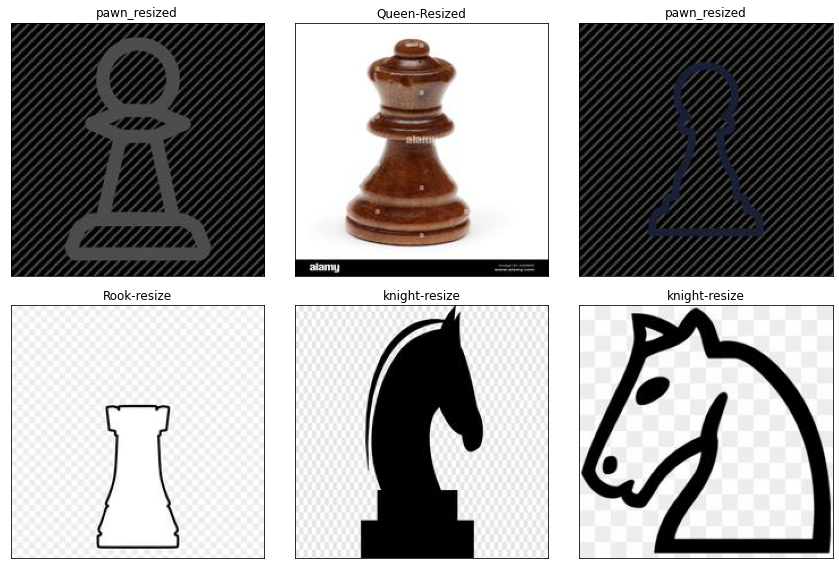

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

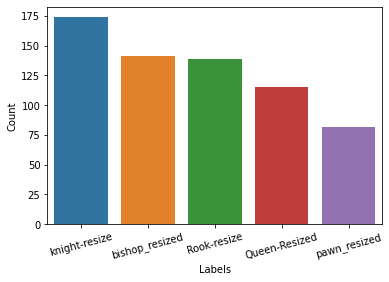

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=15);

<a id="4"></a> <br>
# ✂️ Train & Test Split

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

<a id="5"></a> <br>
# 🦾 Function

In [ ]:
def func(pre,name_model,size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    
    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=1);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

<a id="6"></a> <br>
# 📚 Training models

# ✔️ InceptionV3

In [ ]:
"""
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = func(preprocess_input,InceptionV3,100)
"""

'\nfrom tensorflow.keras.applications import InceptionV3\nfrom tensorflow.keras.applications.inception_v3 import preprocess_input\nresult_InceptionV3 = func(preprocess_input,InceptionV3,100)\n'

# ✔️ NasNetLarge 

In [ ]:
"""
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
result_NASNetLarge = func(preprocess_input,NASNetLarge,331)
"""

'\nfrom tensorflow.keras.applications import NASNetLarge\nfrom tensorflow.keras.applications.nasnet import preprocess_input\nresult_NASNetLarge = func(preprocess_input,NASNetLarge,331)\n'

# ✔️ NASNetMobile

# ✔️ InceptionResNetV2

# ✔️ DenseNet201

# ✔️ EfficientNetB7

# ✔️ ResNet50

# ✔️ ResNet152

# ✔️ MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
result_MobileNetV2 = func(preprocess_input,MobileNetV2,100)

#####~Model => <function MobileNetV2 at 0x7e021fbbf320> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [Errno -3] Temporary failure in name resolution

# ✔️ ResNet101V2

<a id="7"></a> <br>
# 📊 Final Report

<h1>Greatly appreciate to leave your comments /suggestions.</h1>
<h1>If you like this notebook please do <span style="color:red">UPVOTE</span>.</h1>